# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

## Problem Statement

Prepare a model which is invariant to the transformations and is able to recognize the varied images.

## Learning Objectives

At the end of the experiment, you will be able to :

* Load and prepare images for the model using Pytorch
* Build and optimize CNN architecture for predicting the labels of the images

In [ ]:
#@title Mini Hackathon Walkthrough Video
from IPython.display import HTML

HTML("""<video width="500" height="300" controls>
  <source src="https://cdn.talentsprint.com/talentsprint/archives/sc/aiml/aiml_batch_14/cnn_image_transformations_mini_hackathon_walkthrough.mp4" type="video/mp4">
</video>
""")

## Dataset

The dataset is comprised of photos of dogs and cats provided as a subset of photos from a much larger dataset of 3 million manually annotated photos. The dataset was developed as a partnership between Petfinder.com and Microsoft.

The Dogs vs. Cats dataset is a standard computer vision dataset that involves classifying photos as either containing a dog or cat. The train folder contains 22,500 images of dogs and cats. Each image in this folder has the label as part of the filename. The test folder contains 2,500 images, named according to a numeric id. For each image in the test set, you should predict a probability that the image is a dog or a cat (1 = dog, 0 = cat).

## Grading = 20 Marks

## Setup Steps

In [1]:
#@title Run this cell to complete the setup for this Notebook

from IPython import get_ipython
ipython = get_ipython()
  
notebook= "M3_Mini_Hackathon3_Image_Transformations" #name of the notebook
Answer = "This notebook is graded by mentors on the day of hackathon"
def setup():
   ipython.magic("sx wget https://cdn.talentsprint.com/aiml/Experiment_related_data/Cat_Dog_data.zip")
   ipython.magic("sx unzip -qq Cat_Dog_data.zip")
   print ("Setup completed successfully")
   return

setup()

Setup completed successfully


In [2]:
%ls

 Cat_Dog_data/     'M3MH3 - VGG16.pkl'   sample_data/
 Cat_Dog_data.zip   __MACOSX/


## Basic Pytorch packages

**torchvision:**  This package is used to load and prepare the dataset. Using this package we can perform/apply transformations on the input data.

**transforms:**  This package is  used to perform preprocessing on images and operations sequentially. 

**nn:**  This package provides an easy and modular way to build and train simple or complex neural networks.

**optim:** This package is used for  implementing various optimization algorithms

In [3]:
pip install split-folders

In [4]:
# Import Libraries
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models, utils
from torch.autograd import Variable
import os
import random
from shutil import copyfile
import splitfolders
import numpy as np
from tqdm.notebook import tqdm

## **Stage 1:** Data Preprocessing

In [5]:
splitfolders.ratio('/content/Cat_Dog_data/train', output="/content/split_data", seed=804, ratio=(0.88, 0.12))

Copying files: 22500 files [00:05, 4379.06 files/s]


### 1 Mark -> Load the train dataset

AxesImage(54,36;334.8x217.44)
(499, 375)


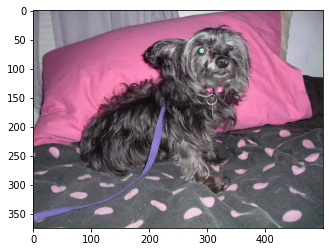

In [6]:
from PIL import Image
img_raw = Image.open("/content/split_data/train/dog/dog.0.jpg")
print(plt.imshow(img_raw))
print(img_raw.size)

In [7]:
!pip install git+https://github.com/aleju/imgaug
from imgaug import augmenters as iaa
import imgaug as ia

  Cloning https://github.com/aleju/imgaug to /tmp/pip-req-build-m_i7yryh
  Running command git clone -q https://github.com/aleju/imgaug /tmp/pip-req-build-m_i7yryh
  Created wheel for imgaug: filename=imgaug-0.4.0-cp36-none-any.whl size=971107 sha256=765c71903ccb9a3df6f520c837acaff1b074a7b2a585cc8b18db6a3c5149e120
  Stored in directory: /tmp/pip-ephem-wheel-cache-b2e6vz1m/wheels/9c/f6/aa/41dcf2f29cc1de1da4ad840ef5393514bead64ac9e644260ff
Successfully built imgaug
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [8]:
class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Resize(image_size),
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Fliplr(0.5),
        iaa.ChangeColorTemperature((1100, 10000)),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)])),
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

In [9]:
image_size = (224,224)
train_trans = transforms.Compose([
    ImgAugTransform(),
    lambda x: Image.fromarray(x),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(image_size),
    # transforms.RandomRotation(degrees=(-90, 90)),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

val_trans = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])


train_set = datasets.ImageFolder('/content/split_data/train', transform = train_trans)
val_set = datasets.ImageFolder('/content/split_data/val', transform = val_trans)

In [ ]:
len(train_set), len(val_set)

(19800, 2700)

In [ ]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=False)

In [ ]:
def show_img(img):
    plt.figure(figsize=(25,25))
    # unnormalize
    img = img / 2 + 0.5  
    npimg = img.numpy()
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

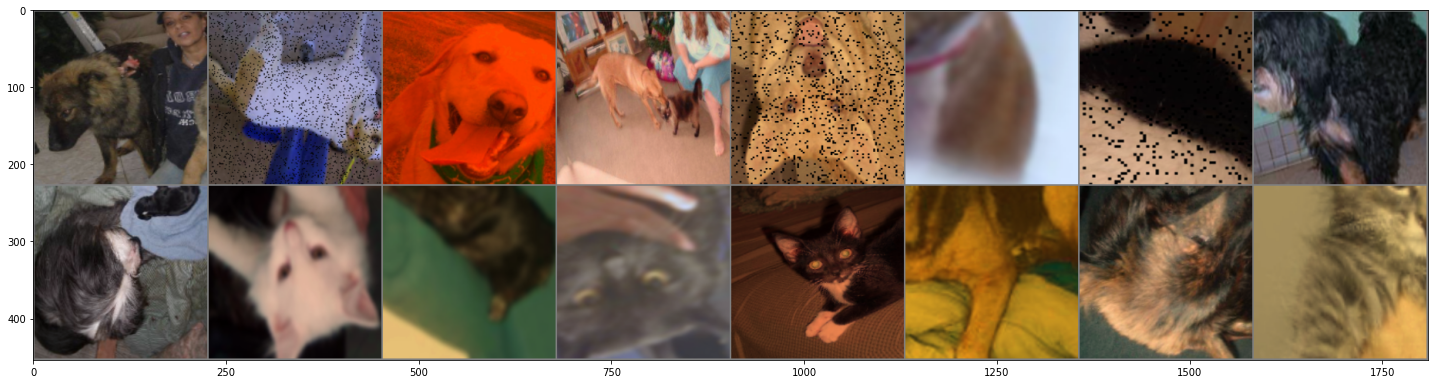

In [ ]:
data = iter(train_loader)
images = data.next()
 
# show images
show_img(utils.make_grid(images[0][:16]))
# len(images[0])

## **Stage 2:** Build and Optimize the CNN model



###  4 Marks -> Create CNN Model and declare the loss function and optimizer. 

[Hint for CNN model](https://medium.com/ml2vec/intro-to-pytorch-with-image-classification-on-a-fashion-clothes-dataset-e589682df0c5)

In [10]:
#Load VGG16 model
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096, out_features=2)

params_to_update = []

update_params_name = ['classifier.6.weight', 'classifier.6.bias']

for name, param in model.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(params=params_to_update)

print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



classifier.6.weight
classifier.6.bias
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_

Initialize the device to available runtime type

In [11]:
### To test whether GPU instance is present in the system of not.
use_cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
device

Using PyTorch version: 1.6.0+cu101 CUDA: True


device(type='cuda')

### 4 Marks -> Train the Model and validate it continuously to calculate the loss and accuracy for the dataset across each epoch.

Iterate over batch-wise images in the train_loader and perform the following steps. 

1. First, zero out the gradients using zero_grad()

2. Convert the inputs, labels to the device (runtime type: GPU or CPU)

3. Pass the input to the model and get the output

4. Calculate the loss by comparing output with actual labels using a Loss function

5. Perform Backward pass using backward() to update the weights

6. Optimize the weights at each epoch and get high probability prediction using the torch.max()

7. Calculate the accuracy of the train dataset using the predictions

**Note:** Optimize the CNN model to get better accuracy.

[Hint for CNN model](https://medium.com/ml2vec/intro-to-pytorch-with-image-classification-on-a-fashion-clothes-dataset-e589682df0c5)

In [ ]:
# YOUR CODE HERE 
# Record loss and accuracy of the train dataset
def train(epoch,loss_vector,acc_vector):
  model.train()
  correct, train_loss = 0,0
  for batch_id, (images, labels) in tqdm(enumerate(train_loader),desc = 'train model'):

      images, labels = images.to(device), labels.to(device)
      
      #1. First, we zero out the gradients using zero_grad()
      optimizer.zero_grad()

      #2. We pass the data to the model
      outputs = model(images)

      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels).sum()

      #3. We calculate the loss using a Loss function
      loss = criterion(outputs, labels)
      train_loss += loss.item()

      #4. Perform Backward pass using backward() to update the weights
      loss.backward()

      #5. Optimize and predict by using the torch.max()
      optimizer.step()
      
  train_loss /= len(train_loader)
  loss_vector.append(train_loss)

  accuracy = 100. * correct/ len(train_loader.dataset)
  acc_vector.append(accuracy)
  # print(f'Train accuracy: {accuracy}; Loss: {train_loss}')

def test(loss_vector, accuracy_vector):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
      for data, target in val_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += criterion(output, target).item()
          pred = torch.max(output.data,1)[1] # get the index of the max log-probability
          correct += pred.eq(target.data).to(device).sum()

    test_loss /= len(val_loader)
    loss_vector.append(test_loss)

    accuracy = 100. * correct / len(val_loader.dataset)
    accuracy_vector.append(accuracy)
    
    # print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #     test_loss, correct, len(test_loader.dataset), accuracy))

In [ ]:
%%time
epochs = 20
model = model.to(device)
losst, acct = [], []
lossv, accv = [], []
for epoch in tqdm(range(1, epochs + 1),desc='epoch'):
    train(epoch, losst, acct)
    test(lossv, accv)
    print('{}: Train set: Acc: {:.2f}% Loss: {:.4f}; Test set: Acc: {:.2f}% Loss: {:.4f}'.format(epoch, acct[-1], losst[-1], accv[-1], lossv[-1]))


1: Train set: Acc: 76.14% Loss: 0.4549; Test set: Acc: 98.04% Loss: 0.0596



2: Train set: Acc: 77.71% Loss: 0.4341; Test set: Acc: 97.93% Loss: 0.0624



3: Train set: Acc: 77.49% Loss: 0.4357; Test set: Acc: 98.07% Loss: 0.0590



4: Train set: Acc: 77.32% Loss: 0.4408; Test set: Acc: 97.96% Loss: 0.0584



5: Train set: Acc: 78.34% Loss: 0.4281; Test set: Acc: 98.15% Loss: 0.0602



6: Train set: Acc: 77.99% Loss: 0.4304; Test set: Acc: 98.22% Loss: 0.0580



7: Train set: Acc: 78.44% Loss: 0.4314; Test set: Acc: 98.04% Loss: 0.0589



8: Train set: Acc: 77.42% Loss: 0.4394; Test set: Acc: 98.37% Loss: 0.0573



9: Train set: Acc: 77.94% Loss: 0.4380; Test set: Acc: 98.04% Loss: 0.0578



10: Train set: Acc: 78.26% Loss: 0.4350; Test set: Acc: 98.19% Loss: 0.0552



11: Train set: Acc: 78.05% Loss: 0.4350; Test set: Acc: 98.19% Loss: 0.0552



12: Train set: Acc: 78.32% Loss: 0.4287; Test set: Acc: 98.37% Loss: 0.0571



13: Train set: Acc: 77.92% Loss: 0.4336; Test set: Acc: 98.07% Loss: 0.0561



14: Train set: Acc: 77.71% Loss: 0.4398; Test set: Acc: 98.30% Loss: 0.0547



15: Train set: Acc: 78.64% Loss: 0.4257; Test set: Acc: 97.93% Loss: 0.0595



16: Train set: Acc: 78.66% Loss: 0.4307; Test set: Acc: 98.11% Loss: 0.0579



17: Train set: Acc: 78.32% Loss: 0.4359; Test set: Acc: 98.15% Loss: 0.0563



18: Train set: Acc: 77.69% Loss: 0.4412; Test set: Acc: 98.00% Loss: 0.0617



19: Train set: Acc: 78.10% Loss: 0.4358; Test set: Acc: 98.11% Loss: 0.0597



20: Train set: Acc: 77.90% Loss: 0.4348; Test set: Acc: 98.07% Loss: 0.0585

CPU times: user 2h 5min 59s, sys: 35min 12s, total: 2h 41min 12s
Wall time: 2h 40min 33s


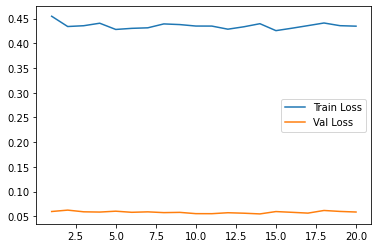

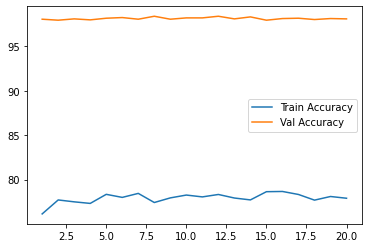

In [ ]:
# losst, acct
# lossv, accv
epoch = range(1,epochs+1)
plt.plot(epoch,losst,label='Train Loss')
plt.plot(epoch,lossv,label='Val Loss')
plt.legend()
plt.show()

plt.plot(epoch,acct,label='Train Accuracy')
plt.plot(epoch,accv,label='Val Accuracy')
plt.legend()
plt.show()

In [ ]:
import joblib
joblib_file = "M3MH3 - VGG16.pkl"  
joblib.dump(model, joblib_file)

['M3MH3 - VGG16.pkl']

## **Stage 3:** Test your final architecture on variations of the Test data.



Variations of the Test data means that you can consider any image transformation such as Brightness, rotate, flip and so on, as shown in the below example. 

![alt text](https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/transformations.png)

### 8 Marks-> Define 6 different types of image transformation (variations) and evaluate for any 4 test samples of Cats and Dogs each.

1. Define 6 image transformations (Eg: Brightness, rotate, flip, and so on). You can use either skimage, PIL, or anything which can give the image transformations.

2. Take a test sample from the test folder and run the below steps
   *  Perform 6 different image transformations for the chosen test sample and plot the same.
   *  Convert the image type of the transformed images, if required.
   *  Call the image_loader function for every transformed image.
   *  Pass through the CNN model to predict the label for each transformed test sample.
   *  Ensure the transformed test sample gives the correct prediction as a cat or dog. 

3. Repeat step 2 for **<font size='4.5'>four </font>** different test samples of cats and dogs each and get correct predictions.

[Hint for the image transformations using skimage](https://www.analyticsvidhya.com/blog/2019/09/9-powerful-tricks-for-working-image-data-skimage-python/)

[Hint for the image transformations using PIL](https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/)

In [ ]:
import joblib
model = joblib.load('/content/M3MH3 - VGG16.pkl')

In [ ]:
# train_trans = transforms.Compose([
#     ImgAugTransform(),
#     lambda x: Image.fromarray(x),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomResizedCrop(image_size),
#     # transforms.RandomRotation(degrees=(-90, 90)),
#     transforms.RandomVerticalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

test_trans = transforms.Compose([
    ImgAugTransform(),
    lambda x: Image.fromarray(x),
    # transforms.RandomResizedCrop(image_size),
    transforms.RandomRotation(degrees=(-90, 90)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomGrayscale(p=0.5),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

test_set = datasets.ImageFolder('/content/Cat_Dog_data/test', transform = test_trans)

In [ ]:
# def image_loader(image):
#     image = torch.utils.data.DataLoader(image)
#     # image = image.to(device)
#     # image = image.unsqueeze(0) # To pass single image through the model
#     return image 

In [13]:
# YOUR CODE HERE for defining 6 different image transformations (eg: Brightness, rotate, flip and so on)
def show_image(img):
  plt.figure(figsize=(2,2))
  # img = test_set[784][0]
  img = img / 2 + 0.5  
  npimg = img.numpy()
  npimg = np.clip(npimg, 0., 1.)
  return np.transpose(npimg, (1, 2, 0))
  # plt.imshow(np.transpose(npimg, (1, 2, 0)))
  # plt.axis('off')
  # plt.show()

In [14]:
# YOUR CODE HERE for predicting the labels of an image for the 6 image transformations
def pred_image(img):
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
      data = img.to(device)
      data = data.unsqueeze(0)
      output = model(data)
      _,pred = torch.max(output.data, 1)
      return test_set.classes[pred]

In [16]:
x = np.random.randint(len(test_set))
print('Predicting a ', test_set.classes[test_set[x][1]])
pred_img = []
pred = []
for _ in range(6):
  test_img = test_set[x][0]
  pred_img.append(show_image(test_img))
  # show_image(test_img)
  # pred_image(test_img)
  pred.append(pred_image(test_img))

NameError: ignored

## **Stage 4:** Report Analysis

### 3 Marks -> Provide your observations on the following:

1. What are the transformations you have considered and why did you choose them.

2. Mention which transformation in your network is most invariant in recognizing the images. Provide the reason.

2. Share your observations for not recognizing the predictions correctly.

In [ ]:
# YOUR TEXT HERE